# Data Preparation
- This notebook is used to visualize and prepare power trace data for our transformer model.

In [1]:
import os
import glob
import re
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, random_split
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional

## Find and load the data

In [2]:
def discover_experiment_pairs(data_root_dir: str) -> List[Tuple[str, str]]:
    """
    Finds matching pairs of power CSVs and results CSVs based on
    {MODEL_NAME}_tp{TP}_p{RATE}_d{DATE}.csv and
    results_{MODEL_NAME}_{RATE}_{TP}_d{DATE}_final.csv.

    Returns:
        A list of (power_csv_path, results_csv_path).
    """
    all_csvs = glob.glob(
        os.path.join(data_root_dir, "**", "*.csv"), recursive=True
    )
    print(f"Found {len(all_csvs)} CSV files in {data_root_dir}")

    # Separate into "power" files vs "results" files
    power_files = []
    results_files = []

    for csv_path in all_csvs:
        base = os.path.basename(csv_path)
        if base.startswith("results_"):
            results_files.append(csv_path)
        else:
            # Likely a power file if it has _tp and _p in the name
            if "_tp" in base and "_p" in base:
                power_files.append(csv_path)

    print(f"Found {len(power_files)} power files and {len(results_files)} results files")
    
    # Attempt to match them by extracting model_name, tp, rate, and date
    def extract_power_info(filename: str):
        # Example: llama-3-8b_tp2_p1.0_d2025-04-07-20-19-17.csv
        base = os.path.basename(filename)
        model_match = re.match(r"(.*)_tp(\d+)_p([\d\.]+)_d(.*).csv", base)
        if not model_match:
            return None
        model_name = model_match.group(1)
        tp = model_match.group(2)
        rate = model_match.group(3)
        date = model_match.group(4)
        return model_name, tp, rate, date

    def extract_results_info(filename: str):
        # Example: results_llama-3-8b_1.0_2_d2025-04-07-20-19-17_final.csv
        base = os.path.basename(filename)
        # Try pattern with date
        result_match = re.match(r"results_(.*)_([\d\.]+)_(\d+)_d(.*)_final.csv", base)
        if not result_match:
            # Try the old pattern without date
            result_match = re.match(r"results_(.*)_([\d\.]+)_(\d+)_final.csv", base)
            if not result_match:
                return None
            model_name = result_match.group(1)
            rate = result_match.group(2)
            tp = result_match.group(3)
            date = None
        else:
            model_name = result_match.group(1)
            rate = result_match.group(2)
            tp = result_match.group(3)
            date = result_match.group(4)
        return model_name, tp, rate, date

    matched_pairs = []
    for pfile in power_files:
        pinfo = extract_power_info(pfile)
        if not pinfo:
            continue
        p_model, p_tp, p_rate, p_date = pinfo

        # Look for a results file that matches
        for rfile in results_files:
            rinfo = extract_results_info(rfile)
            if not rinfo:
                continue
            r_model, r_tp, r_rate, r_date = rinfo

            # Check if they match on model, tp, and rate
            if p_model == r_model and p_tp == r_tp and p_rate == r_rate:
                # If date is available in both, check if it matches
                if p_date and r_date:
                    if p_date == r_date:
                        matched_pairs.append((pfile, rfile))
                        break  # Found our match with date
                else:
                    # No date information, match by other criteria
                    matched_pairs.append((pfile, rfile))
                    break  # Found our match without date

    print(
        f"Found {len(power_files)} power files, {len(results_files)} results files, "
        f"matched {len(matched_pairs)} pairs."
    )
    return matched_pairs


def parse_results_csv(csv_path: str) -> pd.DataFrame:
    """
    Parse the results CSV.
    
    Expects columns:
    [Request Time, Model, Data Source, Poisson Arrival Rate, Tensor Parallel Size,
     Input Tokens, Output Tokens, E2E Latency]

    Returns:
        Pandas DataFrame with a 'Completion Time' column.
    """
    try:
        df = pd.read_csv(csv_path)
        df.sort_values("Request Time", inplace=True)
        df["Completion Time"] = df["Request Time"] + df["E2E Latency"]
        return df
    except Exception as e:
        print(f"Error reading results file {csv_path}: {e}")
        return pd.DataFrame()


def parse_power_csv(csv_path: str) -> pd.DataFrame:
    """
    Parse the GPU power trace CSV and sum up the first X power values of each group of 8 rows,
    where X is the tensor parallelism extracted from the filename (_tpX).
    The timestamp for each sample is taken as the minimum timestamp within the group.
    
    Expects columns (for each GPU row):
        timestamp, power.draw [W], utilization.gpu [%], memory.used [MiB]
    """
    try:
        # Read CSV and clean up column names
        df = pd.read_csv(csv_path, skipinitialspace=True)
        df.columns = [col.strip().lower() for col in df.columns]

        # Rename power and memory columns if needed
        if "power.draw [w]" in df.columns:
            df.rename(columns={"power.draw [w]": "power"}, inplace=True)
            df.rename(columns={"memory.used [mib]": "memory"}, inplace=True)

        # Clean up the power column (remove non-numeric characters and convert to numeric)
        if df["power"].dtype == object:
            df["power"] = df["power"].replace(r"[^\d.]", "", regex=True)
            df["power"] = pd.to_numeric(df["power"])

        # Clean up the memory column if present
        if "memory" in df.columns and df["memory"].dtype == object:
            df["memory"] = df["memory"].replace(r"[^\d.]", "", regex=True)
            df["memory"] = pd.to_numeric(df["memory"])

        # Identify the timestamp column (any column containing "time")
        time_col = None
        for c in df.columns:
            if "time" in c:
                time_col = c
                break
        if not time_col:
            raise ValueError("No timestamp column found in power CSV")

        # Convert timestamps to datetime and rename column to "timestamp"
        df[time_col] = pd.to_datetime(df[time_col])
        df.rename(columns={time_col: "timestamp"}, inplace=True)

        # Extract tensor parallelism from the filename (_tpX -> X)
        tp_match = re.search(r'_tp(\d+)', csv_path)
        tensor_parallelism = int(tp_match.group(1)) if tp_match else 1
        print(f"Extracted tensor parallelism {tensor_parallelism} from {csv_path}")
        
        # Group by 8 rows (8 GPUs per node)
        num_rows = len(df)
        num_complete_groups = num_rows // 8
        df = df.iloc[:num_complete_groups * 8]
        groups = df.groupby(np.arange(len(df)) // 8)

        result = groups.apply(lambda x: pd.Series({
            "timestamp": x["timestamp"].min(),
            "power": x.iloc[:tensor_parallelism]["power"].sum()
        })).reset_index(drop=True)

        result["timestamp"] = pd.to_datetime(result['timestamp']).astype(np.int64) / 10**9

        return result

    except Exception as e:
        print(f"Error reading power file {csv_path}: {e}")
        return pd.DataFrame()


def extract_experiment_info(power_csv_path: str):
    """
    Extract experiment information from the power CSV filename.
    
    Args:
        power_csv_path: Path to the power CSV file
        
    Returns:
        Dict with model_name, tp, rate, and date
    """
    base = os.path.basename(power_csv_path)
    model_match = re.match(r"(.*)_tp(\d+)_p([\d\.]+)_d(.*).csv", base)
    if not model_match:
        return None
    
    return {
        "model_name": model_match.group(1),
        "tp": int(model_match.group(2)),
        "rate": float(model_match.group(3)),
        "date": model_match.group(4)
    }


def load_and_process_experiments(data_root_dir: str, exclude_patterns=None):
    """
    Load and process all experiment pairs, organizing them into coordinated lists.
    
    Args:
        data_root_dir: Root directory to search for CSV files
        exclude_patterns: List of patterns to exclude (e.g., ['deepseek'])
        
    Returns:
        power_dfs: List of power dataframes
        results_dfs: List of results dataframes
        experiment_info: List of dictionaries with experiment metadata
    """
    # Find matching experiment pairs
    matched_pairs = discover_experiment_pairs(data_root_dir)
    
    # Filter out excluded patterns
    if exclude_patterns:
        filtered_pairs = []
        for pair in matched_pairs:
            should_include = True
            for pattern in exclude_patterns:
                if (pattern.lower() in pair[0].lower() or 
                    pattern.lower() in pair[1].lower()):
                    should_include = False
                    break
            if should_include:
                filtered_pairs.append(pair)
        
        print(f"Filtered out {len(matched_pairs) - len(filtered_pairs)} pairs. Remaining pairs: {len(filtered_pairs)}")
        matched_pairs = filtered_pairs
    
    # Process each pair
    power_dfs = []
    results_dfs = []
    experiment_info = []
    
    for power_csv, results_csv in matched_pairs:
        print(f"Processing {power_csv} and {results_csv}")
        
        # Extract experiment information
        info = extract_experiment_info(power_csv)
        if not info:
            print(f"Could not extract experiment info from {power_csv}")
            continue
        
        # Parse CSV files
        power_df = parse_power_csv(power_csv)
        results_df = parse_results_csv(results_csv)
        
        # Skip if parsing failed
        if power_df.empty or results_df.empty:
            print(f"Skipping empty dataframes for {power_csv} and {results_csv}")
            continue
        
        # Add to our lists
        power_dfs.append(power_df)
        results_dfs.append(results_df)
        experiment_info.append(info)
    
    print(f"Successfully processed {len(power_dfs)} experiment pairs")
    return power_dfs, results_dfs, experiment_info

def plot_power_val(df: pd.DataFrame, title: str, ylabel: str, xlabel: str, save_path: Optional[str] = None):
    plt.figure(figsize=(12, 6))
    plt.plot(df["timestamp"], df["power"], label="Power")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()  # Fixed from plt.legCompletion()
    if save_path:
        plt.savefig(save_path)
    plt.show()


In [3]:
power_dfs, results_dfs, experiment_info = load_and_process_experiments(
        "../client", 
        exclude_patterns=["deepseek"]
    )


Found 248 CSV files in ../client
Found 83 power files and 165 results files
Found 83 power files, 165 results files, matched 83 pairs.
Filtered out 24 pairs. Remaining pairs: 59
Processing ../client/llama-3-8b/llama-3-8b_tp2_p2.0_d2025-03-14-07-32-35.csv and ../client/llama-3-8b/results_llama-3-8b_2.0_2_d2025-03-14-07-32-35_final.csv
Extracted tensor parallelism 2 from ../client/llama-3-8b/llama-3-8b_tp2_p2.0_d2025-03-14-07-32-35.csv
Processing ../client/llama-3-8b/llama-3-8b_tp1_p1.0_d2025-03-13-18-38-32.csv and ../client/llama-3-8b/results_llama-3-8b_1.0_1_final.csv
Extracted tensor parallelism 1 from ../client/llama-3-8b/llama-3-8b_tp1_p1.0_d2025-03-13-18-38-32.csv
Processing ../client/llama-3-8b/llama-3-8b_tp8_p4.0_d2025-03-14-01-22-15.csv and ../client/llama-3-8b/results_llama-3-8b_4.0_8_final.csv
Extracted tensor parallelism 8 from ../client/llama-3-8b/llama-3-8b_tp8_p4.0_d2025-03-14-01-22-15.csv
Processing ../client/llama-3-8b/llama-3-8b_tp4_p1.0_d2025-03-13-22-02-25.csv and ../

/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2495564371.py:157: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col])


Processing ../client/llama-3-8b/llama-3-8b_tp8_p0.125_d2025-04-07-22-09-26.csv and ../client/llama-3-8b/results_llama-3-8b_0.125_8_final.csv
Extracted tensor parallelism 8 from ../client/llama-3-8b/llama-3-8b_tp8_p0.125_d2025-04-07-22-09-26.csv
Processing ../client/llama-3-8b/llama-3-8b_tp1_p0.5_d2025-03-13-18-28-09.csv and ../client/llama-3-8b/results_llama-3-8b_0.5_1_d2025-03-13-18-28-09_final.csv
Extracted tensor parallelism 1 from ../client/llama-3-8b/llama-3-8b_tp1_p0.5_d2025-03-13-18-28-09.csv
Processing ../client/llama-3-8b/llama-3-8b_tp8_p0.5_d2025-03-14-00-42-29.csv and ../client/llama-3-8b/results_llama-3-8b_0.5_8_d2025-03-14-00-42-29_final.csv
Extracted tensor parallelism 8 from ../client/llama-3-8b/llama-3-8b_tp8_p0.5_d2025-03-14-00-42-29.csv
Processing ../client/llama-3-8b/llama-3-8b_tp1_p0.125_d2025-04-07-17-43-57.csv and ../client/llama-3-8b/results_llama-3-8b_0.125_1_d2025-04-07-17-43-57_final.csv
Extracted tensor parallelism 1 from ../client/llama-3-8b/llama-3-8b_tp1_p

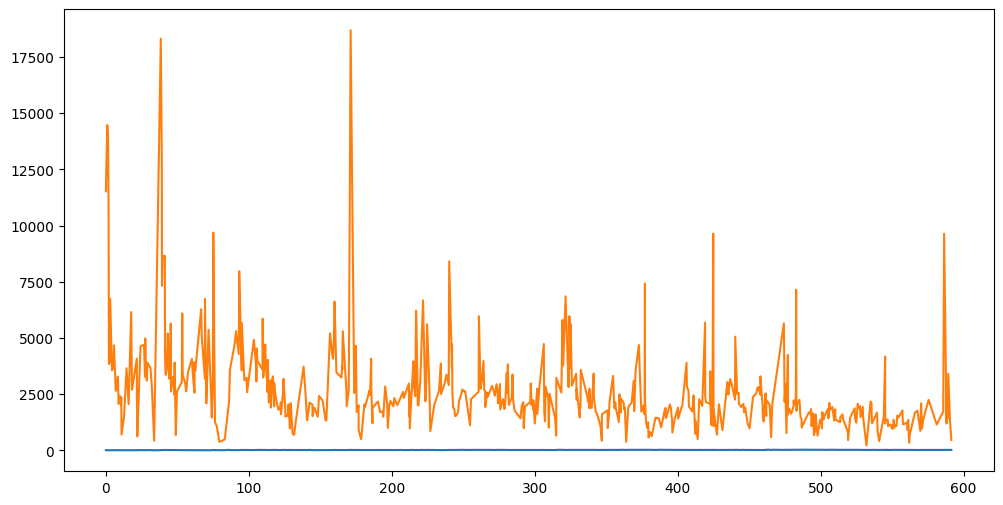

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(results_dfs[-9]["Request Time"], results_dfs[-9]["Decode Throughput"])
plt.plot(results_dfs[-9]["Request Time"], results_dfs[-9]["Prefill Throughput"])
# plt.plot(results_dfs[-10]["Request Time"], results_dfs[-10]["Decode Tokens"])
plt.show()

In [4]:
# check that power and results dataframes have same date for their timestamps
sort_power_dfs = power_dfs.copy()
sort_results_dfs = results_dfs.copy()
for i in range(len(sort_power_dfs)):
    print(sort_results_dfs[i]["Request Time"].min())
    sort_power_dfs[i]["timestamp"] -= sort_power_dfs[i]["timestamp"].min() 
    sort_results_dfs[i]["Completion Time"] -= sort_results_dfs[i]["Request Time"].min()
    sort_results_dfs[i]["Request Time"] -= sort_results_dfs[i]["Request Time"].min()
    poisson_arrival_rate = results_dfs[i]["Poisson Arrival Rate"].iloc[0]
    # simulated_arrival_time = np.random.exponential(1.0 / poisson_arrival_rate)
    # sort_results_dfs[i]["Request Time"] += simulated_arrival_time
    # sort_results_dfs[i]["Completion Time"] += simulated_arrival_time


print("Power DataFrames:")
# for power_df in sort_power_dfs:
#     print(power_df.head())
print("Results DataFrames:")
for results_df in sort_results_dfs:
    print(results_df[["Request Time", "Completion Time"]].max())

1741937560.878573
1741891119.777445
1741915346.864126
1741903351.746496
1741911682.517254
1741897551.327436
1741911682.517254
1741890495.8032024
1741912957.8819664
1744047856.5104916
1744067164.603584
1744050460.766742
1741904177.3988993
1741902114.3935857
1741936648.1052427
1741889866.0289073
1741896296.33864
1741912288.7379112
1741913585.4726243
1741913585.4726243
1741905071.6300757
1744065046.474823
1741938348.9734733
1741901520.2507925
1741897551.327436
1741903351.746496
1741912288.7379112
1741901520.2507925
1744060701.370441
1741902114.3935857
1741889256.8060467
1744057888.4532793
1741904177.3988993
1741891943.4178183
1741938348.9734733
1741890495.8032024
1741896296.33864
1741891119.777445
1744051244.9265902
1744048459.350503
1741896902.8381352
1741936648.1052427
1741914431.233133
1741905071.6300757
1741914431.233133
1741896902.8381352
1741902725.786608
1745373395.0243497
1745371368.187842
1745366006.861244
1745363855.9463558
1745362696.1492116
1745360054.4074745
1745367936.219948

Startup time:  0.0
Shutdown time:  599.1853489875793
Power date:  1969-12-31 16:00:00
Startup time:  0.0
Shutdown time:  599.1853489875793
Power date:  1969-12-31 16:00:00
Startup time:  0.0
Shutdown time:  598.0739252567291
Power date:  1969-12-31 16:00:00
Startup time:  0.0
Shutdown time:  598.4569211006165
Power date:  1969-12-31 16:00:00
Startup time:  0.0
Shutdown time:  598.9914886951447
Power date:  1969-12-31 16:00:00
Startup time:  0.0
Shutdown time:  598.1964876651764
Power date:  1969-12-31 16:00:00
Startup time:  0.0
Shutdown time:  598.2925922870636
Power date:  1969-12-31 16:00:00
Startup time:  0.0
Shutdown time:  598.1964876651764
Power date:  1969-12-31 16:00:00
Startup time:  0.0
Shutdown time:  599.1522204875946
Power date:  1969-12-31 16:00:00
Startup time:  0.0
Shutdown time:  596.8263583183289
Power date:  1969-12-31 16:00:00
Startup time:  0.0
Shutdown time:  581.9741716384888
Power date:  1969-12-31 16:00:00
Startup time:  0.0
Shutdown time:  598.8465116024017
P

/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_24817/509635340.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truncated_power_dfs[i]['timestamp'] -= truncated_power_dfs[i]['timestamp'].min()
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_24817/509635340.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["input_tokens"] = input_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_24817/509635340.py:58: SettingWithCopyWarning: 
A value is trying to be

2375 805
2372 599
2349 1234
2346 568
2357 81
2371 283
2346 81
2375 299
2350 273
2294 73
2365 1150
2367 880
2361 1075
2330 145
2361 580
2352 130
2314 81
2359 130
2334 555
2352 555
2367 1129
2360 329
2371 1028
2310 78
2371 283
2370 568
2345 130
2289 78
2357 295
2333 145
2118 71
2370 1176
2363 1075
2374 883
2360 1028
2373 299
2317 81
2367 599
2377 1130
2332 143
2365 145
2351 580
2375 1093
2353 1129
2363 1093
2365 145
2351 313


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_24817/509635340.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["input_tokens"] = input_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_24817/509635340.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["output_tokens"] = output_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_24817/509635340.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

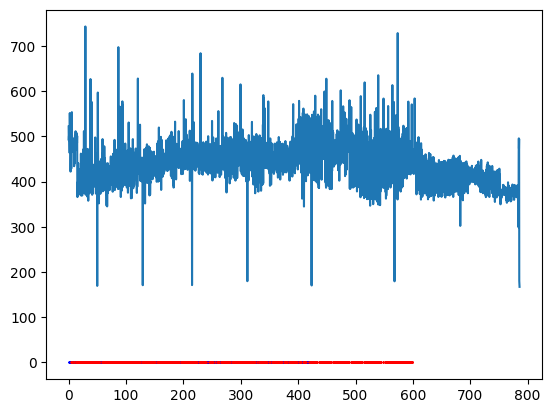

In [121]:
import datetime
def add_token_columns_to_power_df(power_df: pd.DataFrame, results_df: pd.DataFrame) -> pd.DataFrame:
    """
    For each 250ms window in power_df, compute the tokens that are being processed by 
    distributing each query's token counts across its processing duration.
    
    Args:
        power_df: DataFrame with a 'timestamp' column (in seconds relative to experiment start).
        results_df: DataFrame from the results CSV. Expects columns:
            - "Request Time" (datetime64)
            - "Completion Time" (datetime64)
            - "Input Tokens"
            - "Output Tokens"
    
    Returns:
        The original power_df with two added columns:
            - "input_tokens": the fraction of input tokens processed in that 250ms window.
            - "output_tokens": the fraction of output tokens processed in that 250ms window.
    """
    # Use the earliest request time as the reference (assumes power_df was truncated accordingly)
    start_time = results_df["Request Time"].min()
    
    # Create new columns with times in seconds relative to start_time
    results_df = results_df.copy()
    results_df["req_sec"] = (results_df["Request Time"] - start_time)
    results_df["comp_sec"] = (results_df["Completion Time"] - start_time)
    
    window_duration = 0.25
    input_tokens_list = []
    output_tokens_list = []

    for t in power_df["timestamp"]:
        window_start = t
        window_end = t + window_duration
        
        overlapping = results_df[(results_df["comp_sec"] > window_start) & (results_df["req_sec"] < window_end)]
        
        total_input = 0.0
        total_output = 0.0
        
        # For each overlapping query, compute the fraction of the query's tokens that were processed in this window.
        for _, row in overlapping.iterrows():
            q_start = row["req_sec"]
            q_end = row["comp_sec"]
            # Compute the overlap (in seconds) between the query interval and the window
            overlap = max(0.0, min(window_end, q_end) - max(window_start, q_start))
            query_duration = q_end - q_start
            if query_duration > 0:
                fraction = overlap / query_duration
                total_input += row["Input Tokens"] * fraction
                total_output += row["Output Tokens"] * fraction
        
        input_tokens_list.append(total_input)
        output_tokens_list.append(total_output)
    
    # Add the new columns to the power_df
    power_df["input_tokens"] = input_tokens_list
    power_df["output_tokens"] = output_tokens_list
    return power_df

plt.plot(power_dfs[0]["timestamp"], power_dfs[0]["power"], label="Power")
plt.scatter(results_dfs[0]["Request Time"], [0] * len(results_dfs[0]), c="blue", marker="x", label="Request Time", s=1)
plt.scatter(results_dfs[0]["Completion Time"], [0] * len(results_dfs[0]), c="red", marker="x", label="Completion Time", s=1)
print("Startup time: ", results_dfs[0]["Request Time"].min() - power_dfs[0]['timestamp'].min())
print("Shutdown time: ", results_dfs[0]["Completion Time"].max() - power_dfs[0]['timestamp'].min())

truncated_power_dfs = []
for i in range(len(sort_power_dfs)):
    date = sort_power_dfs[i]['timestamp'].min()
    print("Power date: ", datetime.datetime.fromtimestamp(date).strftime('%Y-%m-%d %H:%M:%S'))
    startup_cutoff = sort_results_dfs[i]["Request Time"].min()
    shutdown_cutoff = sort_results_dfs[i]["Completion Time"].max()
    print("Startup time: ", startup_cutoff - date)
    print("Shutdown time: ", shutdown_cutoff - date)
    truncated_power_dfs.append(sort_power_dfs[i][(sort_power_dfs[i]['timestamp'] > startup_cutoff) & (sort_power_dfs[i]['timestamp'] < shutdown_cutoff)])
    truncated_power_dfs[i].reset_index(drop=True, inplace=True)
    truncated_power_dfs[i]['timestamp'] -= truncated_power_dfs[i]['timestamp'].min()

for i in range(len(truncated_power_dfs)):
    # get date of timestamp power)
    truncated_power_dfs[i] = add_token_columns_to_power_df(truncated_power_dfs[i], sort_results_dfs[i])

output_path = "processed_data/power_trace_data.npz"
input_tokens = []
output_tokens = []
tensor_parallelism = []
poisson_rate = []
model_sizes = [] 
power_traces = []

# First pass to get max length
max_len = max([len(df) for df in truncated_power_dfs])

for i in range(len(truncated_power_dfs)):
    print(len(truncated_power_dfs[i]), len(sort_results_dfs[i]))
    tensor_parallelism.append(sort_results_dfs[i]["Tensor Parallel Size"].iloc[0])
    poisson_rate.append(sort_results_dfs[i]["Poisson Arrival Rate"].iloc[0])
    model_sizes.append(sort_results_dfs[i]["Input Tokens"].iloc[0])
    
    # Pad power traces and token arrays to max length
    power_trace = truncated_power_dfs[i]["power"].values
    input_token = truncated_power_dfs[i]["input_tokens"].values
    output_token = truncated_power_dfs[i]["output_tokens"].values

    # Pad with zeros to maintain homogeneity
    power_trace = np.pad(power_trace, (0, max_len - len(power_trace)), 'edge')
    input_token = np.pad(input_token, (0, max_len - len(input_token)), 'constant', constant_values=0)
    output_token = np.pad(output_token, (0, max_len - len(output_token)), 'constant', constant_values=0)
    
    power_traces.append(power_trace)
    input_tokens.append(input_token)
    output_tokens.append(output_token)

# Convert to numpy arrays
power_traces = np.array(power_traces)
tensor_parallelism = np.array(tensor_parallelism)
poisson_rate = np.array(poisson_rate)
model_sizes = np.array(model_sizes)
input_tokens = np.array(input_tokens)
output_tokens = np.array(output_tokens)

np.savez(output_path, 
         power_traces=power_traces, 
         tensor_parallelism=tensor_parallelism, 
         poisson_rate=poisson_rate, 
         model_sizes=model_sizes, 
         input_tokens=input_tokens, 
         output_tokens=output_tokens)
